In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve

Define the function to compute the kernel given the weights and the degree of the polynomial

In [3]:
def compute_LPA_kernel(w, N):
    # compute the LPA kernel for a given weights and polynomial degree
    # input:
    #   w: vector containing the weights for the local LS problem
    #   N: degree of the polynomial approximation
    # return:
    #   g: the computed LPA kernel

    # compute the kernel
    M = len(w)
    t = np.linspace(-1, 1, M)
    T = np.column_stack([t**i for i in range(N+1)])

    # generate the inverse of weights
    winv = [1 / w_i if w_i != 0 else 0 for w_i in w]

    # set to zero weights that are inf
    # winv = np.where(winv == np.inf, 0, winv)
    # define the weight matrix
    W = np.diag(w)
    Winv = np.diag(winv)
    Q, R = np.linalg.qr(T)

    #  define Qtilde
    Qtilde =  np.dot(Winv, Q)

    # adjust Qtilde with the  weights matrix squared.
    W2Qtilde = np.dot(W**2, Qtilde)

    # select the central row of W2Qtilde
    row = M // 2

    # compute the kernel
    g = np.sum(W2Qtilde[row, l] * W2Qtilde[:, l] for l in range(N + 1))

    # flipping, since it is used in convolution
    g = g[::-1]

    # normalization
    g = g / np.sum(g)


    return g


LPA-ICI
-------
Set the LPA-ICI parameters

In [4]:
# maximum degree of polynomial used for fitting
N = 3

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 50
all_h = np.arange(N, hmax+1)

Generate the signal

Text(0.5, 1.0, 'Input Signal')

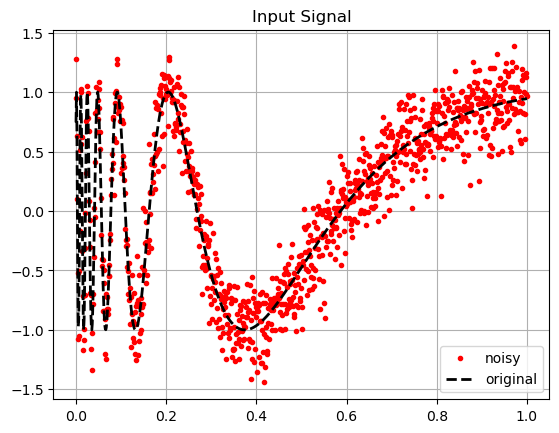

In [5]:
LENGTH = 1000

ty = np.linspace(0, 1, LENGTH)
y = np.sin(2 / (ty + 0.05))

#  noise standard deviation
sigma = 0.2

# noisy signal
s = y + sigma*np.random.normal(size=LENGTH)


plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Generate the LPA kernels for all the scale. Use centered weights.


In [6]:
all_g = []
for i in range(len(all_h)):
    # define the weights for the scale h (symmetric, left or right)
    w = np.ones(2*all_h[i]+1)
    # compute and store the kernel g
    # TODO: implement the function compute_LPA_kernel
    g = compute_LPA_kernel(w, N)

    all_g.append(g)

/var/folders/w2/bgswx5pn3hjb55_vz5h2hw4m0000gn/T/ipykernel_99068/3402855686.py:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  g = np.sum(W2Qtilde[row, l] * W2Qtilde[:, l] for l in range(N + 1))


Initialize all the variables for the ICI rule

In [7]:
# initialize the estimate
y_hat = np.zeros(LENGTH)

# initialize the vector containing the best scale for each sample
best_scale = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
lower_bounds = -np.inf*np.ones(LENGTH)
upper_bounds = np.inf*np.ones(LENGTH)

Loop over all the scales

In [8]:
for i, h in enumerate(all_h):
    g = all_g[i]

    # compute the estimate for the scale h
    yhat_h = convolve(s, g, 'same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma * sigma
    ub = yhat_h + Gamma * sigma
    
    # update the lower and upper bounds
    lower_bounds = np.where(lb < lower_bounds, lower_bounds, lb)
    upper_bounds = np.where(ub > upper_bounds, upper_bounds, ub)

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    best_scale = np.where(lower_bounds < upper_bounds, h, best_scale)

    # update the estimate
    yhat = np.where(lower_bounds < upper_bounds, yhat_h, y_hat)

Use the best scale for each sample to compute the final estimates



In [9]:
yhat_final = yhat

/var/folders/w2/bgswx5pn3hjb55_vz5h2hw4m0000gn/T/ipykernel_99068/3677056126.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m-" (-> color='m'). The keyword argument will take precedence.
  ax[0].plot(ty, yhat_final, 'm-', linewidth=3, color = 'blue')


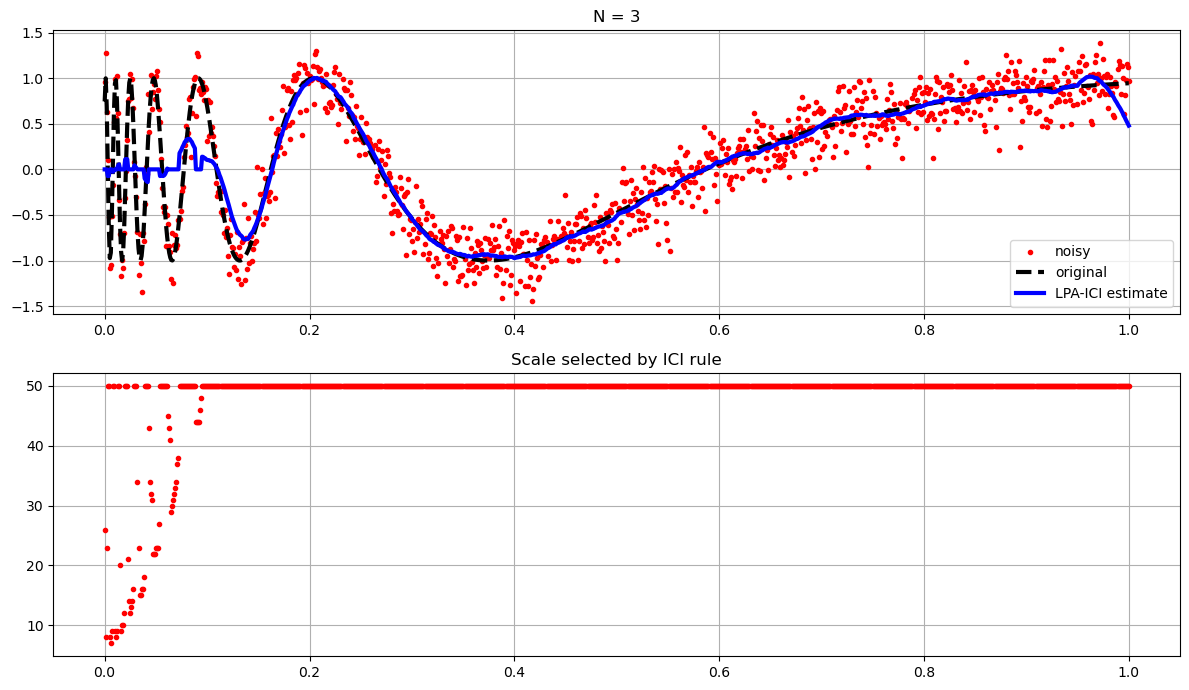

In [10]:
fig, ax = plt.subplots(2, 1, figsize = (12,7))
ax[0].plot(ty, s, 'r.')
ax[0].plot(ty, y, 'k--', linewidth=3)
ax[0].plot(ty, yhat_final, 'm-', linewidth=3, color = 'blue')
ax[0].grid()
ax[0].legend(['noisy', 'original', 'LPA-ICI estimate'])
ax[0].set_title(f'N = {N:d}')

ax[1].plot(ty, best_scale, 'r.')
ax[1].set_title('Scale selected by ICI rule')
ax[1].grid()

fig.tight_layout()
plt.show()

LPA-ICI with Aggregation
------------------------
Set the parameters


In [22]:
# maximum degree of polynomial used for fitting
N = 2

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 51
all_h = np.arange(N + 1, hmax+1)

Generate synthetic signal signal

Text(0.5, 1.0, 'Input Signal')

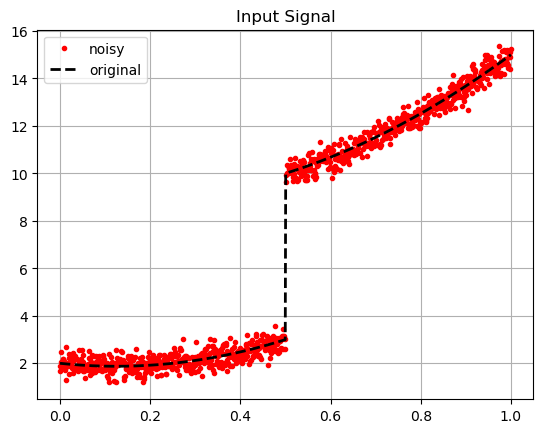

In [23]:
LENGTH = 1000
ty = np.linspace(0, 1, LENGTH)
y = 8 * ty ** 2 - 2*ty + 2
y[ty >0.5] = y[ty >0.5] + 7

#  noise standard deviation
sigma = 0.3

# noisy signal
s = y + sigma*np.random.normal(size=LENGTH)


plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Generate the LPA kernels for all the scale for both left and right windows

In [24]:
all_g_left = []
all_g_right = []

for i, h in enumerate(all_h):
    # define the weights for the scale h (left)
    # first half is one, second is zero
    w = np.concatenate([np.ones(h // 2 + 1), np.zeros(h // 2)])
    g_left = compute_LPA_kernel(w, N)
    all_g_left.append(g_left)

    # define the weights for the scale h (right)
    # first half is zero, second is one
    w = np.concatenate([np.zeros(h // 2), np.ones(h // 2 + 1)])
    g_right = compute_LPA_kernel(w, N)
    all_g_right.append(g_right)

/var/folders/w2/bgswx5pn3hjb55_vz5h2hw4m0000gn/T/ipykernel_99068/3402855686.py:34: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  g = np.sum(W2Qtilde[row, l] * W2Qtilde[:, l] for l in range(N + 1))


Use the LPA-ICI to compute the estimate based on the **left** kernels

Text(0.5, 1.0, 'Variance of the left estimate')

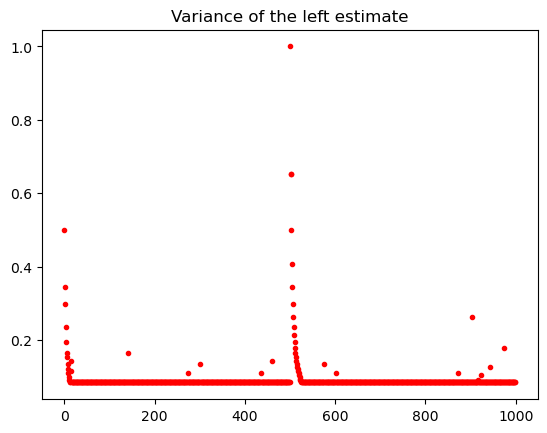

In [25]:
# initialize the left estimate
yhat_left = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
lower_bounds = -np.inf*np.ones(LENGTH)
upper_bounds = np.inf*np.ones(LENGTH)

# intialize the vector containing the variance of the estimator for each sample
var_left = np.zeros(LENGTH)

for i, h in enumerate(all_h):
    g = all_g_left[i]

    # compute the estimate for the scale h
    yhat_h = convolve(s, g, 'same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma * sigma * np.linalg.norm(g)
    ub = yhat_h + Gamma * sigma * np.linalg.norm(g)

    # update the lower and upper bounds
    lower_bounds = np.where(lb < lower_bounds, lower_bounds, lb)
    upper_bounds = np.where(ub > upper_bounds, upper_bounds, ub)

    # update the estimate
    yhat_left = np.where(lower_bounds < upper_bounds, yhat_h, yhat_left)

    # update the variance
    # TODO: da rivedere
    var_left = np.where(lower_bounds < upper_bounds, np.linalg.norm(g)**2, var_left)

# plot var left
plt.figure()
plt.plot(var_left, 'r.')

plt.title('Variance of the left estimate')

Use the LPA-ICI to compute the estimate based on the **right** kernels

In [26]:
# initialize the right estimate
yhat_right = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
lower_bounds = -np.inf*np.ones(LENGTH)
upper_bounds = np.inf*np.ones(LENGTH)

# intialize the vector containing the variance of the estimator for each sample
var_right = np.zeros(LENGTH)

for i, h in enumerate(all_h):
    g = all_g_left[i]

    # compute the estimate for the scale h
    yhat_h = convolve(s, g, 'same')

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma * sigma
    ub = yhat_h + Gamma * sigma

    # update the lower and upper bounds
    lower_bounds = np.where(lb < lower_bounds, lower_bounds, lb)
    upper_bounds = np.where(ub > upper_bounds, upper_bounds, ub)

    # update the estimate
    yhat_right = np.where(lower_bounds < upper_bounds, yhat_h, yhat_right)

    # update the variance
    var_right = np.where(lower_bounds < upper_bounds, sigma**2 * np.linalg.norm(g)**2, var_right)

Text(0.5, 1.0, 'Variance of the right estimate')

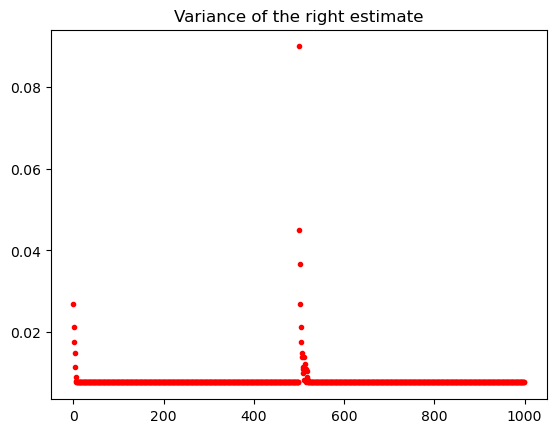

In [27]:
# plot the variance of the right estimate
plt.figure()
plt.plot(var_right, 'r.')
plt.title('Variance of the right estimate')

Perform the aggregation


In [28]:
# yhat_aggr =  1/2 * (yhat_left + yhat_right)

w_left = 1 / var_left
w_right = 1 / var_right

yhat_aggr = (w_left * yhat_left + w_right * yhat_right) / (w_left + w_right)

Text(0.5, 1.0, 'N = 2')

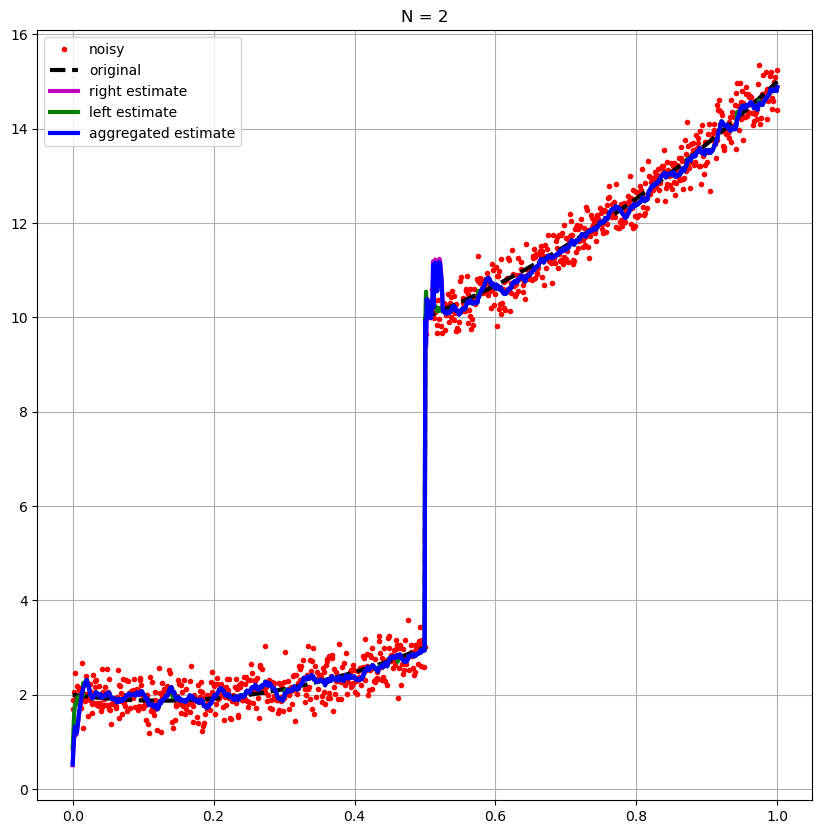

In [29]:
plt.figure(figsize=(10,10))
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, yhat_right, 'm-', linewidth=3)
plt.plot(ty, yhat_left, 'g-', linewidth=3)
plt.plot(ty, yhat_aggr, 'b-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'right estimate', 'left estimate', 'aggregated estimate'])
plt.title(f'N = {N:d}')
